# Sentiment Analysis

## Build Model

In [3]:
import pandas as pd

df = pd.read_csv("Data\Genshin_Impact.csv",encoding='utf-8')
df.dropna(subset = ["content"], inplace = True)
df.drop_duplicates(keep = "first", inplace = True)
print(str(df.shape[0]) + " comments and their related information are scrapped from Bilibili Game Center.")
df.head()

256732 comments and their related information are scrapped from Bilibili Game Center.


,Unnamed: 0,name,level,datetime,content,grade,up,down,rcount
0,0,bili_235060966,5,2019-06-07 17:31:06,在？我是第一个预约的吗？,8,21,11,3
1,1,KAMISAMA是阿笑,5,2019-06-07 17:35:17,期待期待,10,6,12,0
2,2,遙かなる夢,5,2019-06-07 17:38:56,来了来了,8,5,10,0
3,3,打倒豆豆,6,2019-06-07 17:46:44,非常的期待,10,5,11,0
4,4,MitsuharuYosaka,5,2019-06-07 17:47:23,好期待啊,10,5,8,0


In [4]:
import jieba

extra_words = ["氪金", "骗氪", "白嫖", "零氪", "微氪", "又肝", 
               "米哈游", "米卫兵", "云玩家", "出货率", "圣遗物", "海灯节", 
               "开放世界", "未来可期", "文化输出", "3A大作", "数值膨胀", "喂不饱的狼"]

for word in extra_words:
    jieba.add_word(word, freq = df[df["content"].str.contains(word)].shape[0])
    
df.drop(df[df["content"].str.contains("|".join(["---", "———", "2019", "2020", "2021"]))].index, inplace = True)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\rgdfy\AppData\Local\Temp\jieba.cache
Loading model cost 0.755 seconds.
Prefix dict has been built successfully.


In [5]:
from sklearn.model_selection import train_test_split

test_ratio = 0.2
seed = 123

pos = df[df["grade"] > 6]["content"]
pos_train, pos_test = train_test_split(pos, test_size = test_ratio, random_state = seed, shuffle = True)
textfile = open("Data/pos.txt", "w",encoding='utf-8')
for comment in pos_train:
    textfile.write(comment + "\n")
textfile.close()

neg = df[df["grade"] <= 6]["content"]
neg_train, neg_test = train_test_split(neg, test_size = test_ratio, random_state = seed, shuffle = True)
textfile = open("Data/neg.txt", "w",encoding='utf-8')
for comment in neg_train:
    textfile.write(comment + "\n")
textfile.close()

In [11]:
from snownlp import sentiment
from snownlp import SnowNLP
from tqdm import tqdm
sentiment.train("Data/neg.txt", "Data/pos.txt")
sentiment.save(r"C:\Users\rgdfy\AppData\Local\Programs\Python\Python38\Lib\site-packages\snownlp\sentiment\sentiment.marshal")
pos_results = [SnowNLP(comment).sentiments for comment in tqdm(pos_test)]
neg_results = [SnowNLP(comment).sentiments for comment in tqdm(neg_test)]

100%|████████████████████████████████████████████████████████████████████████████| 26831/26831 [06:30<00:00, 68.63it/s]


In [12]:
accuracy = []
thresholds = [i / 1000 for i in range(1001)]
for x in thresholds:
    correct = 0
    for result in pos_results:
        if (result >= x):
            correct += 1
    for result in neg_results:
        if (result < x):
            correct += 1
    accuracy.append(correct / (len(pos_test) + len(neg_test)) * 100)
threhold = accuracy.index(max(accuracy)) / 1000
print("Accuracy: " + str(round(max(accuracy), 2)) + "%")

Accuracy: 79.22%


## Apply Model to Video Comments

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from snownlp import sentiment
from snownlp import SnowNLP
from tqdm import tqdm

In [14]:
df = pd.read_csv("43.csv")
#df.drop("Unnamed: 0", axis = 1, inplace = True)
df.dropna(subset = ["content"], inplace = True)
df.drop_duplicates(keep = "first", inplace = True)
print(str(df.shape[0]) + " comments and their related information are scrapped from Target Video.")
df.head()

63939 comments and their related information are scrapped from Target Video.


,mid,name,datetime,type,content
0,702014461,韵豐恵,2023/12/8 19:46,0,原来是今天吗
1,405233012,乐的梦幻,2023/12/8 19:46,0,开了
2,1925658916,蓝星上的分原子,2023/12/8 19:46,0,我的流量[撇嘴][撇嘴][撇嘴]
3,1655969602,李信yyds我爱李信,2023/12/8 19:46,0,差点就给忘了
4,299613087,骚玖不骚,2023/12/8 19:46,0,后面的是.


In [15]:
df["date"] = [t.split(" ")[0] for t in list(df["datetime"])]
df["sentiment"] = [1 if SnowNLP(comment).sentiments >= threhold else -1 for comment in list(df["content"])]

### Simple Polarity Analysis

In [23]:
df

,mid,name,datetime,type,content,date,sentiment
0,702014461,韵豐恵,2023/12/8 19:46,0,原来是今天吗,2023/12/8,-1
1,405233012,乐的梦幻,2023/12/8 19:46,0,开了,2023/12/8,-1
2,1925658916,蓝星上的分原子,2023/12/8 19:46,0,我的流量[撇嘴][撇嘴][撇嘴],2023/12/8,1
3,1655969602,李信yyds我爱李信,2023/12/8 19:46,0,差点就给忘了,2023/12/8,1
4,299613087,骚玖不骚,2023/12/8 19:46,0,后面的是.,2023/12/8,-1
...,...,...,...,...,...,...,...
68549,173279517,水流三生,2023/12/8 21:35,0,什么恶魔甲方[dog],2023/12/8,-1
68550,2011427523,喜欢吃仙贝雪饼,2023/12/8 21:35,0,就没了,2023/12/8,-1
68551,435411123,且散愁心,2023/12/8 21:35,0,家人们，拜拜,2023/12/8,-1
68552,1895515151,心烦的许飞,2023/12/8 21:35,0,牛逼,2023/12/8,-1


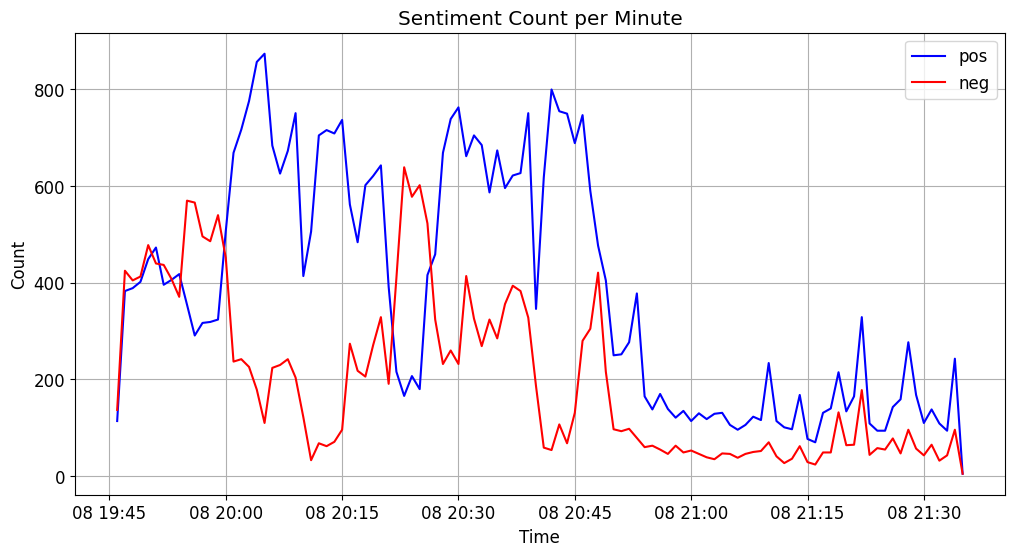

In [24]:
df['datetime'] = pd.to_datetime(df['datetime'])

# 按分钟分组并统计每分钟 sentiment 值为1和-1的数量
positive_sentiments = df[df['sentiment'] == 1].groupby(pd.Grouper(key='datetime', freq='T')).size()
negative_sentiments = df[df['sentiment'] == -1].groupby(pd.Grouper(key='datetime', freq='T')).size()

# 合并两个Series，并填充NaN为0
summary = pd.concat([positive_sentiments.rename('pos'), negative_sentiments.rename('neg')], axis=1).fillna(0)

# 画图
plt.figure(figsize=(12, 6))

plt.plot(summary.index, summary['pos'], label='pos', color='blue')
plt.plot(summary.index, summary['neg'], label='neg', color='red')

plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Sentiment Count per Minute')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
df1

,rpid,oid,mid,name,level,datetime,content,like,rcount,date,sentiment
0,5479781237,720739815,24839224,IKEHOSHI,5,2021-09-28 12:00:44,？！刚刚,6,0,2021-09-28,1
1,5479773459,720739815,152431077,晚睡会飘,5,2021-09-28 12:00:46,生日快乐呀,2,0,2021-09-28,1
2,5479773554,720739815,37922740,PalpitaZz,5,2021-09-28 12:00:49,来了,2,0,2021-09-28,-1
3,5479781553,720739815,124668951,戰丨星神,5,2021-09-28 12:00:52,[热词系列_好耶],15,0,2021-09-28,1
4,5479777337,720739815,122549284,呆小麻,5,2021-09-28 12:00:52,来咯,4,0,2021-09-28,-1
...,...,...,...,...,...,...,...,...,...,...,...
73483,5550835976,720739815,22738659,沉粕,6,2021-10-08 22:20:46,我来给爹感恩戴德了[doge],3,0,2021-10-08,1
73484,5552223716,720739815,11204302,Faizゞ,5,2021-10-09 07:12:36,BV1Jf4y1c7ri,2,1,2021-10-09,1
73485,5553389126,720739815,87644,bili_87644,5,2021-10-09 12:41:55,加强心海加强心海加强心海加强心海加强心海加强心海加强心海加强心海加强心海加强心海加强心海加强...,2,0,2021-10-09,1
73486,5555829297,720739815,639706141,河南落榜美术生,4,2021-10-09 20:18:34,[热词系列_打卡],0,0,2021-10-09,1


In [25]:
sentiment_df = df[df['sentiment'] == -1]

# 统计出现次数最多的15个mid
top_15_mids = sentiment_df['mid'].value_counts().head(15)

# 打印 mid 和出现次数及其对应的 content 和 level 值
for mid, count in top_15_mids.items():
    subset = sentiment_df[sentiment_df['mid'] == mid]
    content_values = subset['content'].tolist()
    x=len(''.join(content_values))
    print(f'mid: {mid}, count: {count},len:{x}')
    print(f'content: {content_values}')
    print('-------------')
print

mid: 3461570000000000, count: 147,len:796
content: ['开门', '开门', '喔', '真的', '老登开门', '开门', '开门', '开门', '开门', '开门', '开门', '西风骑士团，开门', '老登开门', '速度开门', '开门', '开门', '开门', '来早了[委屈]', '[花]', '开门', '你在哪儿啊', '来了', '开门', '开门', '开门', '这弹幕刷这么多块，我都看不清呀', '池子是什么', '开门', '剃刀不要满定轨了', '开门，西风骑士团', '原神，启动！', '开门[花]', '开门', '开门，黑狼', '开门', '开开开', '开门开门', '开门', '开门开门开门[花]', '开门', '开门', '一', '开门', '开门', '开门', '我是山里灵活的钩', '凌华开门，我是哥', '龙王，你是个什么龙王', '拍电“影”[dog]', '、', '盒盒盒盒盒盒', '钟离', '小草神', '小草神', '玫瑰与铳枪', '弓箭手准备放箭', '放箭放箭放箭放箭放箭放箭放箭', '打公子（剧情）打到一半来看直播了', '原神启动', '草神', '竟然没有男角色，M桑怎么回事', '所以他是岩 元素是吗', '做贼心虚', '强度感人，花瓶仓管', '明花蔓舵', '明花蔓舵', '明花蔓舵', '明花蔓舵明花蔓舵明花蔓舵', '明花蔓舵', '明花蔓舵明花蔓舵明花蔓舵明花蔓舵', '明花蔓舵明花蔓舵明花蔓舵', '明花蔓舵', '明花蔓舵', '明花蔓舵', '明花蔓舵明花蔓舵', '明花蔓舵明花蔓舵明花蔓舵', '明花蔓舵', '明花蔓舵', '明花蔓舵', '明花蔓舵', '明花蔓舵', '明花蔓舵明花蔓舵', '明花蔓舵明花蔓舵明花蔓舵', '1', '‘特级光效’', '又是老活动换皮环节', '没看懂[手机]', '明花蔓舵', '用脚都能玩', '要变3个咯', '为什么不拿林尼演示', '[花]', '爹！！！', '义父！', '爹！（撕心裂肺）', '原神，你就是我亲爹[dog]', '屁股', '啊', '啥玩意？', '?', '吓得我直接删了·－·', '啊？', '我去，一键派遣', '坐牢坐牢[手机][

<function print>

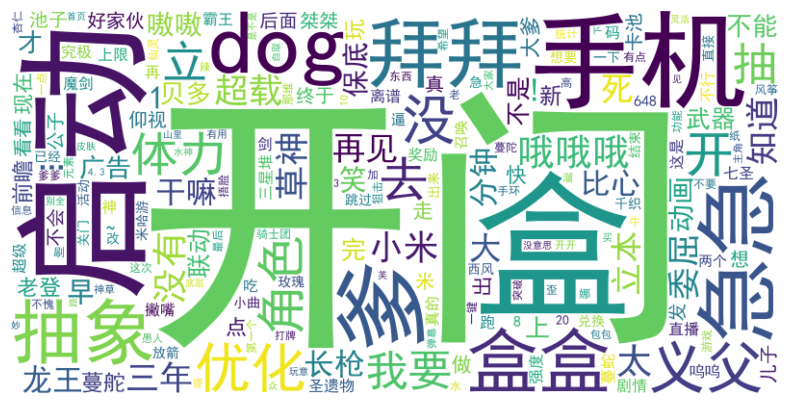

In [26]:
sentiment_df = df[df['sentiment'] == -1]
from wordcloud import WordCloud

# 统计出现次数最多的15个mid
sentiment_df = df[df['sentiment'] == -1]

# 统计出现次数最多的15个mid
top_15_mids = sentiment_df['mid'].value_counts().head(3544)

# 汇总所有选定mid的content值
all_content = []
for mid in top_15_mids.index:
    content_values = sentiment_df[sentiment_df['mid'] == mid]['content'].tolist()
    all_content.extend(content_values)

# 将所有content值连接成一个字符串，同时移除换行符和多余空格
text = ' '.join(all_content).replace('\n', ' ').replace('\r', ' ').strip()

# 使用 jieba 分词
words = jieba.lcut(text)

# 加载停用词表
with open('hit_stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# 去除停用词
words = [word for word in words if word not in stopwords and len(word.strip()) > 0]

# 使用 pandas 计算每个词的频率
word_freq = pd.Series(words).value_counts()

# 生成词云
wordcloud = WordCloud(width=800, height=400, font_path='simhei.ttf', background_color='white').generate_from_frequencies(word_freq)

# 显示词云
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
plt.show()

In [27]:
word_freq.head(10)

开门     2867
盒       432
启动      318
手机      265
爹       190
dog     180
急急      158
拜拜      135
抽象      121
盒盒      120
Name: count, dtype: int64

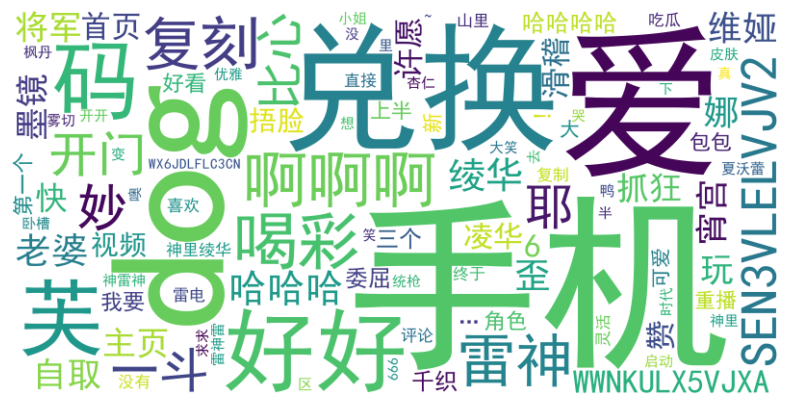

In [28]:
from wordcloud import WordCloud

# 统计出现次数最多的15个mid
sentiment_df = df[df['sentiment'] == 1]

# 统计出现次数最多的15个mid
top_15_mids = sentiment_df['mid'].value_counts().head(3544)

# 汇总所有选定mid的content值
all_content = []
for mid in top_15_mids.index:
    content_values = sentiment_df[sentiment_df['mid'] == mid]['content'].tolist()
    all_content.extend(content_values)

# 将所有content值连接成一个字符串，同时移除换行符和多余空格
text = ' '.join(all_content).replace('\n', ' ').replace('\r', ' ').strip()

# 使用 jieba 分词
words = jieba.lcut(text)

# 加载停用词表
with open('hit_stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# 去除停用词
words = [word for word in words if word not in stopwords and len(word.strip()) > 0 ]

# 使用 pandas 计算每个词的频率
word_freq = pd.Series(words).value_counts()

# 生成词云
wordcloud = WordCloud(width=800, height=400, font_path='simhei.ttf', background_color='white',max_words=100).generate_from_frequencies(word_freq)

# 显示词云
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
plt.show()

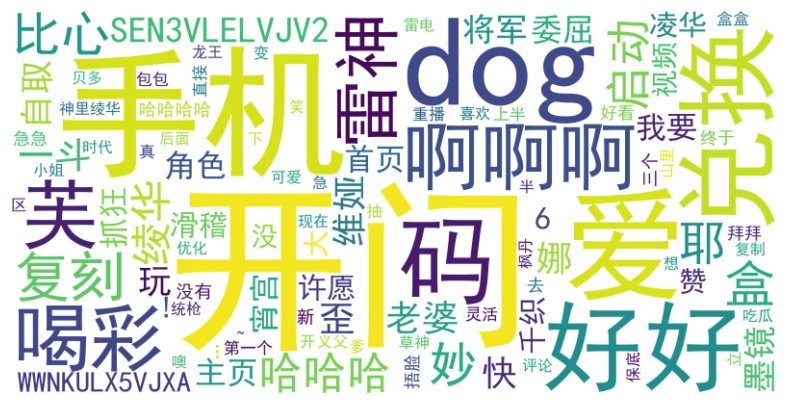

In [29]:
from wordcloud import WordCloud

# 统计出现次数最多的15个mid
sentiment_df = df

# 统计出现次数最多的15个mid
top_15_mids = sentiment_df['mid'].value_counts().head(4544)

# 汇总所有选定mid的content值
all_content = []
for mid in top_15_mids.index:
    content_values = sentiment_df[sentiment_df['mid'] == mid]['content'].tolist()
    all_content.extend(content_values)

# 将所有content值连接成一个字符串，同时移除换行符和多余空格
text = ' '.join(all_content).replace('\n', ' ').replace('\r', ' ').strip()

# 使用 jieba 分词
words = jieba.lcut(text)

# 加载停用词表
with open('hit_stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# 去除停用词
words = [word for word in words if word not in stopwords and len(word.strip()) > 0]

# 使用 pandas 计算每个词的频率
word_freq = pd.Series(words).value_counts()

# 生成词云
wordcloud = WordCloud(width=800, height=400, font_path='simhei.ttf', background_color='white',max_words=100).generate_from_frequencies(word_freq)

# 显示词云
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
plt.show()

In [30]:
word_freq[:30]

开门              2958
手机              1789
dog             1365
爱               1214
兑换               833
好好               765
码                739
啊啊啊              678
芙                660
喝彩               627
雷神               503
复刻               503
盒                433
比心               399
妙                383
耶                373
启动               360
哈哈哈              336
绫华               328
SEN3VLELVJV2     316
一斗               316
歪                309
娜                305
老婆               301
维娅               280
快                279
自取               264
墨镜               251
玩                250
将军               238
Name: count, dtype: int64